##### Training the model 

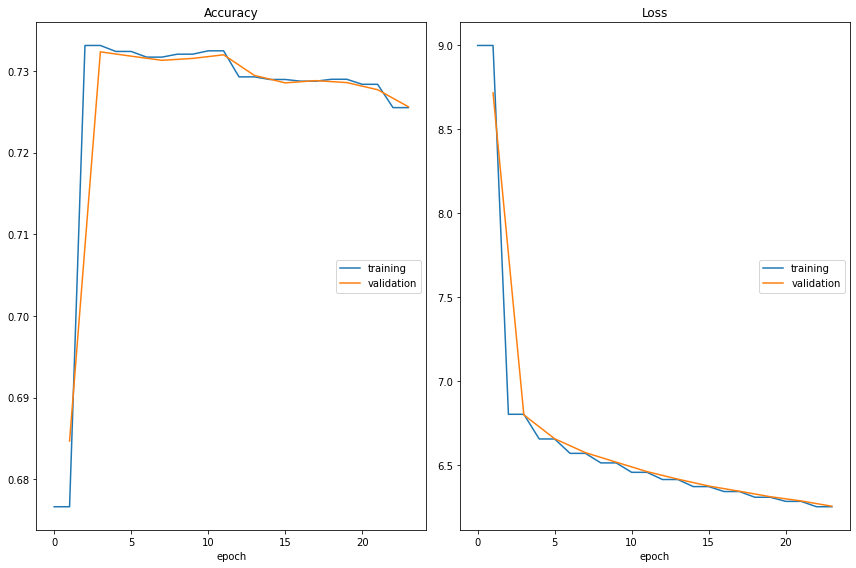

Accuracy
	training         	 (min:    0.677, max:    0.733, cur:    0.726)
	validation       	 (min:    0.685, max:    0.732, cur:    0.726)
Loss
	training         	 (min:    6.251, max:    8.999, cur:    6.251)
	validation       	 (min:    6.254, max:    8.716, cur:    6.254)

epoch 12/12
Best val Acc: 0.732346


In [ ]:
!wget -nc http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
!tar xf mmimdb-256.tar.gz
!pip install livelossplot --quiet
!pip -q install transformers
import torch, os, json
import matplotlib.pyplot as plt
from PIL import Image

from transformers import get_linear_schedule_with_warmup 

def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0


class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'dataset-resized-256max', split = 'dev',
                 image_transform = None):
        self.json_dir = os.path.join(folder, split, 'metadata')
        self.image_dir = os.path.join(folder, split, 'images')
        self.image_transform = image_transform

        # Category definitions of movies.
        self.categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 
                           'Family', 'Fantasy', 'Film-Noir', 'History', 
                           'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname)))) 
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')


            
    def __getitem__(self, index: int):
        # Load images on the fly.
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        genres = movie_data['genres']

        if self.image_transform: image = self.image_transform(image)

        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)), dtype=torch.float32)
        label_ids = [self.categories2ids[cat] for cat in genres]
        label_vector[label_ids] = 1

        return image, label_vector

    def load_image_only(self, index: int):
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        return image

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def __len__(self):
        return len(self.metadata)

val_data = MovieDataset(split = 'dev')
print('Data size: %d samples' % len(val_data))

import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 4)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)






_, (imgs, labels) = next(enumerate(val_loader))
print(imgs.shape, labels.shape)

import matplotlib.pyplot as plt
import numpy as np 
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy 
from livelossplot import PlotLosses

dataset_sizes = {}

dataset_sizes['train'] = len(trainset)
dataset_sizes['val'] = len(valset)
# randomly selecting batches of 4 from training data 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# creating dictionary of dataloaders 
dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = val_loader


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    since = time.time()
    plotlosses = PlotLosses()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    index = 0
    for epoch in range(num_epochs):
        logs = {}
        # Each epoch has a training and validation phase
        cum_loss = 0.0
        cum_acc = 0.0
        correct = 0
        num_samples = 0 

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Setting model to appropriate mode (train/evaluate)
            else:
                model.eval()  

            

            for inputs, labels in dataloaders[phase]: # sending to GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # clearing the old gradients from the previous step 
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): 
                    outputs = model(inputs) # computing predictions 
                    
                    loss = criterion(outputs, labels) # calculating loss 

                    # computing gradients and updating weights if in training mode
                    if phase == 'train':
                        loss.mean().backward() # computing derivative w.r.t loss
                        optimizer.step() 
                #cum_loss += loss.sum().item() 
                cum_acc += top5_accuracy(outputs, labels).sum().item()
                num_samples += inputs.size(0)
                cum_loss += loss.data.sum().item()
            if phase == 'train':
                scheduler.step() # adjusting based on gradient

            curr_loss = cum_loss / num_samples
            curr_acc = cum_acc / num_samples
            
            if phase == 'train':
              logs['loss'] = curr_loss
              logs['acc'] = curr_acc
            else:
              logs['val_loss'] = curr_loss
              logs['val_acc'] = curr_acc
            
            plotlosses.update(logs)
            plotlosses.send() 

            # keeping track of best weights 
            if phase == 'val' and curr_acc > best_acc:
                best_acc = curr_acc
                best_model_weights = copy.deepcopy(model.state_dict())



        print()
        print(f'epoch {epoch+1}/{num_epochs}')

    if scheduler != -1:
        scheduler.step()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_weights)

    torch.save(model.state_dict(), 'best_model_so_far-rohan4.pth') 

    return model



cnn_model = models.resnet18(pretrained=True) # weights optimized for ImageNet data


for param in cnn_model.parameters(): # freezing parameters 
  param.requires_grad = False

num_ftrs = cnn_model.fc.in_features # getting number of input features from last layer
cnn_model.fc = nn.Linear(num_ftrs, len(trainset.categories)) # creating new fully connected layer

cnn_model = cnn_model.to(device) # sending model to device
criterion = nn.BCEWithLogitsLoss(reduction = 'none') # using BCEWithLogitsLoss for multi-class prediction 


optimizer = optim.AdamW(cnn_model.parameters(), lr = 1e-5, eps = 1e-8)

num_epochs = 12

total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps) 


cnn_model = train_model(cnn_model, criterion, optimizer, scheduler, num_epochs)









